In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import colorsys
import seaborn as sns
import datetime

In [2]:
#Gets the image.
img = cv2.imread('RSE25.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
og_img = img.copy() #create duplicate version of img
# cv2.imshow('img', img)

def show_img(img):
    plt.figure(figsize=(15,15))
    plt.imshow(img)
    plt.axis('off')
    # plt.title('my picture')
    plt.show()
    
# show_img(img)

In [3]:
# RSE25, RSE26, RSE29, RSE30
# intersections = np.array([[323, 666], [430, 656], [944, 179], [1011, 61]])

# for intersection in intersections:
#     cv2.circle(img, intersection, 18, [0,0,0], -1)

# show_img(img)

In [4]:
data = pd.read_csv("RSE25_sorted_.csv") #REading the data
# data.head()

In [5]:
# data.describe()

In [6]:
# data.info()

In [7]:
# data.nunique()

In [8]:
#Cycledata contains data for the major road, and mcycle data contains data for the minor road
cycleData = pd.DataFrame(columns=['cycle_num', 'timestamp', 'cumtime', 'redtime', 'greentime', 'yellowtime'])
mcycleData = pd.DataFrame(columns=['cycle_num', 'timestamp', 'cumtime', 'redtime', 'greentime', 'yellowtime'])
# cycleData.head()

In [9]:
#Renaming columns to make it easier to use. 
data = data[['Timestamp', 'CurrentIndication_MajorStreet', 'Duration_Indication_MajorStreet', 'CurrentIndication_MinorStreet', 'Duration_Indication_MinorStreet']]
data = data.rename(columns={'CurrentIndication_MajorStreet':'signal', 'Duration_Indication_MajorStreet':'duration', 'CurrentIndication_MinorStreet':'m_signal', 'Duration_Indication_MinorStreet':'m_duration'})

#making sure durations are not negative
data['duration'] = np.where((data['duration'] < 0.), 0, data['duration'])
data['m_duration'] = np.where((data['m_duration'] < 0.), 0, data['m_duration'])


# data.head()

In [10]:
#This code comes from CycleData.py file provided on the Github: https://github.com/glenntu15/MMITSS_archive
#It calculates if a cycle was completed
class CycleData():
    hadState0 = False
    hadState1 = False;
    hadState2 = False;
    first_indicator = 0
    last_indicator = 0
    stateOrder = []
    redtime = 0.
    greentime = 0.
    yellowtime = 0.
    
    def InitStateVars(self, current_indicator):
        CycleData.hadState0 = True  #Always start with state one
        CycleData.hadState1 = False;
        CycleData.hadState2 = False;
        
        CycleData.first_indicator = current_indicator
        CycleData.last_indicator = current_indicator
        
        # The order of the cycle.
        # We could get rid of the yellow state = 4
        if (current_indicator == 1):
            CycleData.stateOrder = [1,3,4]
        if (current_indicator == 3):
            CycleData.stateOrder = [3,4,1]
        if (current_indicator == 4):
            CycleData.stateOrder = [4,1,3]
        
        #These automatically get set to 0 on the start of a new cycle. 
        CycleData.redtime = 0.
        CycleData.greentime = 0.
        CycleData.yellowtime = 0.
        
    def IsCompleteCycle(self, current_indicator):
        #Did we go through each state. if so, then a new cycle begins
        if( CycleData.hadState0 and CycleData.hadState1 and CycleData.hadState2):  
            #If the indicators don't match up between the completed cycle and the new one, 
            #Then there was an error with the new cycle. 
            if (current_indicator != CycleData.stateOrder[0]):
                #If the indicators 
                print(" ERROR===> start state skipped-- new record generated")
                status = 2  # true with error
            else:
                status = 1  # just fine, new cycle
                
            #Reset the states since it is a new cycle
            CycleData.hadState0 = True
            CycleData.hadState1 = False
            CycleData.hadState2 = False
            CycleData.last_indicator = current_indicator
            return status
        
        else:  # where are we in the cycle
            if (current_indicator == CycleData.stateOrder[1]):
                if (CycleData.hadState1):
                    print(" ERROR== repeat of state 1")
                else:
                    CycleData.hadState1 = True
            if (current_indicator == CycleData.stateOrder[2]):
                if (CycleData.hadState2):
                    print(" ERROR== repeat of state 2")
                else:
                    CycleData.hadState2 = True
            return 0 #Still in current cycle

In [11]:
# This function calculate the cycle_num, timestamp, cumulative time, red light time, green light time, yellow light time
def getCycle(data, cycleData, signal_str, duration_str):
#     print(signal)
    cycle = CycleData()
    rows = data.itertuples()
    prev = next(rows)
    numCycles = 0
    c_datetime = 0
    cycle.InitStateVars(getattr(prev, signal_str))
    
    for row in rows:
        prev_signal = getattr(prev, signal_str)
        signal = getattr(row, signal_str)
        if signal != prev_signal:
            isCycle = cycle.IsCompleteCycle(signal)
            if isCycle == 1:
                numCycles+=1
#                 Appending values into dataframe
                cycleData = cycleData.append({'cycle_num': numCycles,
                                              'timestamp': c_datetime,
                                              'cumtime': CycleData.redtime + CycleData.greentime + CycleData.yellowtime,
                                              'redtime': CycleData.redtime,
                                              'greentime':CycleData.greentime,
                                              'yellowtime': CycleData.yellowtime}, ignore_index=True)

            #Append green, yellow, red times into cycleData
            #Reset variables
            #cycle++
            
#         Updating the value based on indicator
        if (signal == 1):
            CycleData.redtime = getattr(row, duration_str)
        elif (signal == 3):
            CycleData.greentime = getattr(row, duration_str)
        elif (signal == 4):
            CycleData.yellowtime = getattr(row, duration_str)
        c_datetime = datetime.datetime.fromtimestamp(getattr(row, 'Timestamp'))

        prev = row #This is at the end of the for loop
    return cycleData

In [12]:
#Calling the functions. 
cycleData = getCycle(data, cycleData, "signal", "duration")
mcycleData = getCycle(data, mcycleData, "m_signal", "m_duration")

 ERROR===> start state skipped-- new record generated
 ERROR== repeat of state 1
 ERROR== repeat of state 1
 ERROR== repeat of state 1
 ERROR== repeat of state 1
 ERROR== repeat of state 1
 ERROR===> start state skipped-- new record generated
 ERROR===> start state skipped-- new record generated
 ERROR== repeat of state 1


In [13]:
# cycleData.describe()

In [14]:
# mcycleData.head()

In [15]:
# mcycleData.describe()

In [16]:
# This creates the 'ratio' variable. It also finds the anomalies in the cycle
def normalizeData(cycleData):
    cycleData['ratio'] = cycleData['greentime'] / (cycleData['redtime'] + cycleData['greentime'])
    # cycleData['ratio'] = (cycleData['ratio'] - cycleData['ratio'].min())/ (cycleData['ratio'].max()-cycleData['ratio'].min())
    cycleData['norm_red'] = (cycleData['redtime'] - cycleData['redtime'].min())/ (cycleData['redtime'].max()-cycleData['redtime'].min())
    cycleData['norm_green'] = (cycleData['greentime'] - cycleData['greentime'].min())/ (cycleData['greentime'].max()-cycleData['greentime'].min())
    cycleData['anomaly'] = 0
    cycleData.describe()
    
# Find anomalies or outliers in the data.     
    upper_bound = cycleData['ratio'].mean() + (3 * cycleData['ratio'].std()) 
    lower_bound= cycleData['ratio'].mean() - (3 * cycleData['ratio'].std())
#     print(lower_bound, upper_bound)
    cycleData['anomaly'] = np.where(cycleData['ratio'] > upper_bound, 1, cycleData['anomaly'])
    cycleData['anomaly'] = np.where(cycleData['ratio'] < lower_bound, 1, cycleData['anomaly'])
    cycleData.loc[cycleData['anomaly'] == 1]
    
    return cycleData

In [17]:
cycleData = normalizeData(cycleData)
mcycleData = normalizeData(mcycleData)

In [18]:
# cycleData.loc[cycleData['anomaly'] == 1]

In [19]:
# mcycleData.loc[mcycleData['anomaly'] == 1]

In [20]:
# Color plot function to display the color value in the timelapse
def color_plot(s):
    if 0 <= s and s <= 0.5:
        hue = 0
        saturation = 1-2*float(s)
    elif 0.5 < s and s <= 1:
        hue = 120
        saturation = (float(s) - 0.5)/(0.5)
    return (hue/360, saturation, 1)

In [22]:
# creates the timelapse video and outputs it. 
def getTimelapse(videoName, cycleData, img):
    height, width, layers = img.shape
    size = (width,height)
    
    # Getting the color scale
    color_figure = cv2.imread("color_scale.PNG")
    color_figure = cv2.cvtColor(color_figure, cv2.COLOR_BGR2RGB)
    
    #Creating a image section to overlap the color circle when there is an anomaly
    img[100:100+color_figure.shape[0], 0:color_figure.shape[1]] = color_figure
    center = img[280:400, 350:500].copy()
    
    #font settings
    font = cv2.FONT_HERSHEY_SIMPLEX
    org = (5, 580)
    fontScale = 0.75
    color = (255, 244, 0)
    thickness = 1
    outline_color = (0,0,0)
    anomaly_count = 0

    text = 'Anomaly Detected in Cycle: '
    
    #Creating video writer
    out = cv2.VideoWriter(videoName,cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
    
    #Iterate through the CycleData and display colored circle, color scale, cycle number, timestamp.
    for row in cycleData.itertuples():
        #Resetting the intersection to not have a colored circle
        img[280:400, 350:500] = center.copy()
        
        # Get the ratio value
        ratio = getattr(row, 'ratio')
        h, s, v = color_plot(ratio)
        r, g, b = colorsys.hsv_to_rgb(h, s, v)
        r = r * 255.
        g = g * 255.
        b = b * 255.
        
        #If the cycle is an anomaly display the notification and yellow ring around the colored circle
        if getattr(row, 'anomaly') == 1:
            cv2.circle(img, [430, 355], 40, [255,244,0], -1)
            anomaly_count+=1
            if anomaly_count > 1:
                text += ', ' + str(int(getattr(row, 'cycle_num')))
            else:
                text += str(int(getattr(row, 'cycle_num')))
            # Using cv2.putText() method
            image = cv2.putText(img, text, org, font, 
                               fontScale, outline_color, thickness*2, cv2.LINE_AA) #Text outline
            image = cv2.putText(img, text, org, font, 
                               fontScale, color, thickness, cv2.LINE_AA)
        cv2.circle(img, [430, 355], 30, [r,g,b], -1)


        # Displaying timestamp and the cycle number
        cv2.rectangle(img, (0, 590), (200, 653), (255,255,255), -1)
        cycleText = "Cycle Number: " + str(int(getattr(row, 'cycle_num')))
        image = cv2.putText(img, str(getattr(row, 'timestamp')), (5, 640), font, 
                               0.5, (1, 1, 1), 1, cv2.LINE_AA)
        image = cv2.putText(img, cycleText, (5, 610), font, 
                               0.5, (1, 1, 1), 1, cv2.LINE_AA)
        out.write(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

    out.release()


In [23]:
getTimelapse('project_Major.mp4', cycleData, img)
getTimelapse('project_Minor.mp4', mcycleData, og_img)

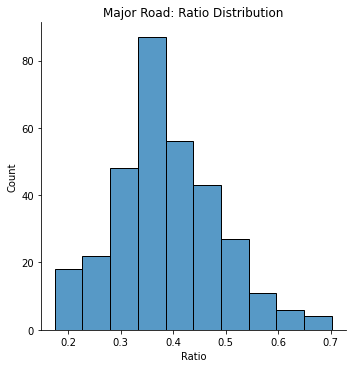

In [24]:
sns.displot(cycleData['ratio'], bins=10, kde=False)
plt.title('Major Road: Ratio Distribution')
plt.xlabel('Ratio')
# plt.show()
plt.savefig('project_Major_Ratio.png')

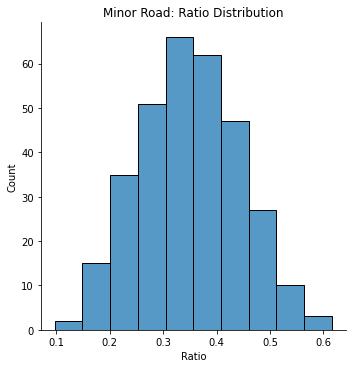

In [25]:
sns.displot(mcycleData['ratio'], bins=10, kde=False)
plt.title('Minor Road: Ratio Distribution')
plt.xlabel('Ratio')
# plt.show()
plt.savefig('project_Minor_Ratio.png')

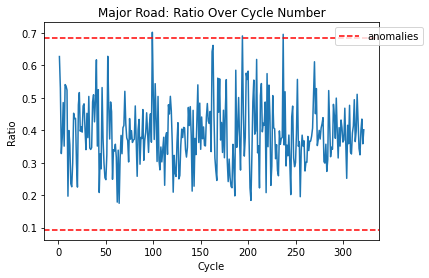

In [26]:
sns.lineplot(x = 'cycle_num', y = 'ratio', data=cycleData)
plt.title('Major Road: Ratio Over Cycle Number')
plt.axhline((cycleData['ratio'].mean() + (3 * cycleData['ratio'].std())), color = 'red', label="anomalies", linestyle='--')
plt.axhline((cycleData['ratio'].mean() - (3 * cycleData['ratio'].std())), color = 'red', linestyle='--')
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper center')
plt.xlabel('Cycle')
plt.ylabel('Ratio')
# plt.show()
plt.savefig('project_Major_ROCN.png')

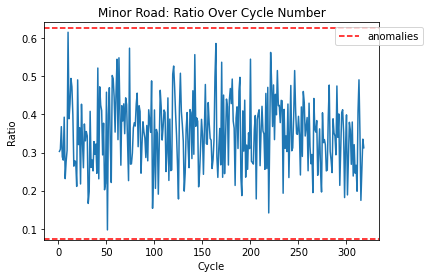

In [27]:
sns.lineplot(x = 'cycle_num', y = 'ratio', data=mcycleData)
plt.title('Minor Road: Ratio Over Cycle Number')
plt.axhline((mcycleData['ratio'].mean() + (3 * mcycleData['ratio'].std())), color = 'red', label="anomalies", linestyle='--')
plt.axhline((mcycleData['ratio'].mean() - (3 * mcycleData['ratio'].std())), color = 'red', linestyle='--')
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper center')
plt.xlabel('Cycle')
plt.ylabel('Ratio')
# plt.show()
plt.savefig('project_Minor_ROCN.png')

In [28]:
# sns.scatterplot(data=cycleData, x='redtime', y='greentime')

In [29]:
# sns.scatterplot(data=cycleData, x='norm_red', y='norm_green')

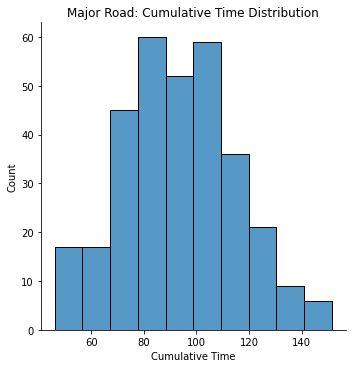

In [30]:
sns.displot(cycleData['cumtime'], bins=10, kde=False)
plt.title('Major Road: Cumulative Time Distribution')
plt.xlabel('Cumulative Time')
# plt.show()
plt.savefig('project_Major_CumulativeTime.png')

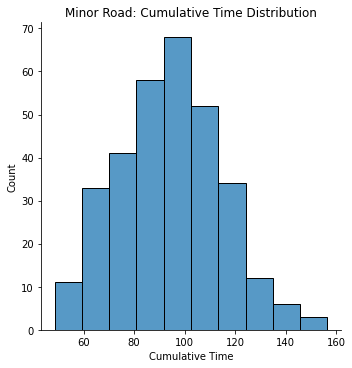

In [31]:
sns.displot(mcycleData['cumtime'], bins=10, kde=False)
plt.title('Minor Road: Cumulative Time Distribution')
plt.xlabel('Cumulative Time')
# plt.show()
plt.savefig('project_Minor_CumulativeTime.png')

In [32]:
# import plotly.express as px
# a = [0, 0.5, 1]
# b = [0, 0.5, 1]

# fig = px.scatter( x=a, y=b, color=b,
#                  color_continuous_scale=[(0, "rgb(255,0,0)"), (0.5, "rgb(255,255,255)"), (1, "rgb(0,255,0)")])

# fig.update_layout(coloraxis_colorbar=dict(
#     title="Ratio"),
#     font_family="sans-serif")

# fig.show()